# クラスタ分析

- [クラスタを階層木として構成する](#クラスタを階層木として構成する)
  - [ボトムアップ方式でのクラスタのグループ化](#ボトムアップ方式でのクラスタのグループ化)
  - [距離行列で階層的クラスタリングを実行する](#距離行列で階層的クラスタリングを実行する)
  - [樹形図をヒートマップと組み合わせる](#樹形図をヒートマップと組み合わせる)
  - [scikit-learnを使って凝集型階層的クラスタリングを適用する](#scikit-learnを使って凝集型階層的クラスタリングを適用する)
- [DBSCANを使って高密度の領域を特定する](#DBSCANを使って高密度の領域を特定する)
- [まとめ](#まとめ)

<br>

In [6]:
from IPython.display import Image
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import japanize_matplotlib
%matplotlib inline
# %config IPCompleter.greedy=True

# クラスタを階層木として構成する

## ボトムアップ方式でのクラスタのグループ化

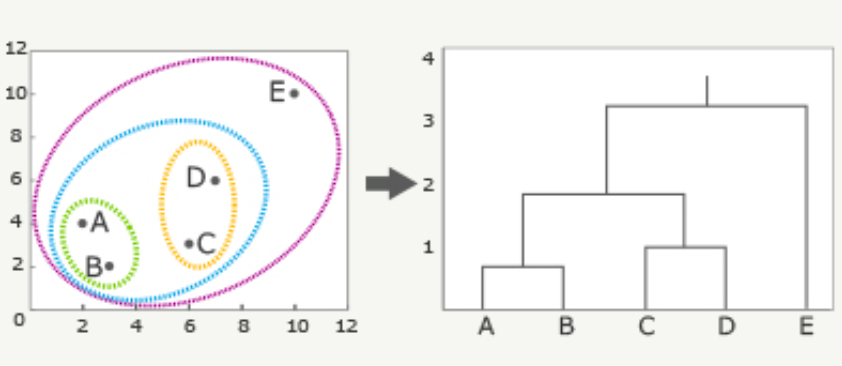

In [4]:
Image(filename='./images/11_0.png', width=600)

### クラスター間の距離の測定方法
- 最短距離法(単連結法) (method = 'single')
- 最長距離法(完全連結法) (method = 'complete')
- 群平均法 (method = 'average')
- 重心法(セントロイド法) (method = 'centroid')
- Ward法(最小分散法) (method = 'Ward')   etc..

[概要説明](https://www.albert2005.co.jp/knowledge/data_mining/cluster/hierarchical_clustering)

### Ward法

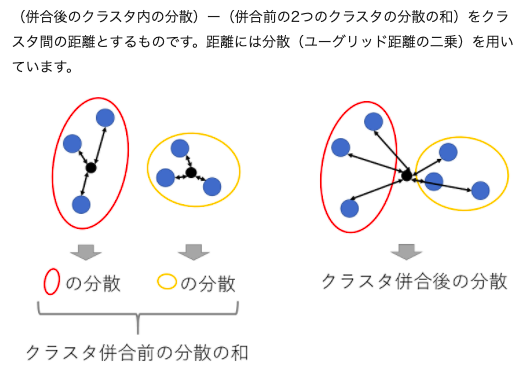

In [3]:
Image(filename='./images/11_1.png', width=600) 

#### $$d(C_1,C_2)=L(C_1\cup C_2)-L(C_1)-L(C_2)$$

### Scipy内でWard法の公式

### $$d(u,v) = \sqrt{\frac{|v|+|s|}{T}d(v,s)^2+\frac{|v|+|t|}{T}d(v,t)^2−\frac{|v|}{T}d(s,t)^2}$$

[scipy.cluster.hierarchy.linkage公式ドキュメント](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html)

In [4]:
#3次元空間に5つのプロット点を生成する。
np.random.seed(123) #乱数生成器のシード固定
variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']

X = np.random.random_sample([5, 3])*10 #random_sampleは0~1の小数を返す
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


<br>

## 距離行列で階層的クラスタリングを実行する

In [11]:
from scipy.spatial.distance import pdist, squareform

#各データ間のユークリッド距離を行列化(対称行列)
row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                        columns=labels,
                        index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


In [12]:
# pdist関数では一行に距離のデータが入る。
print(pdist(df, metric='euclidean'))

[4.973534   5.51665266 5.89988504 3.83539555 4.34707339 5.10431109
 6.69823298 7.24426159 8.31659367 4.382864  ]


<br>

[注意] `pdist`関数から凝縮距離行列（上三角）を渡すか、"元の "データ配列を渡して` linkage`で `metric = 'euclidean'`引数を定義することができます。ただし、全体的なクラスタリングは同じである可能性がありますが、異なる距離値を生成する正方形の距離行列を渡すべきではありません。

In [13]:
# 1. 正しくないアプローチ: row_distをそのまま渡す
from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

/var/folders/yw/rhny6n8d2252w05hgg3j0rcw0000gn/T/ipykernel_15643/1796748898.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  row_clusters = linkage(row_dist, method='complete', metric='euclidean')


,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0


In [10]:
# 2. 正しいアプローチ: pdistを渡す

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1) 
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


In [35]:
# 3. 正しいアプローチ: そのままdfの座標データを渡す

row_clusters = linkage(df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


row_labelの説明。あんまり意味ないけど笑
対応するやり方を別のスクリーンショットを開いて説明する。

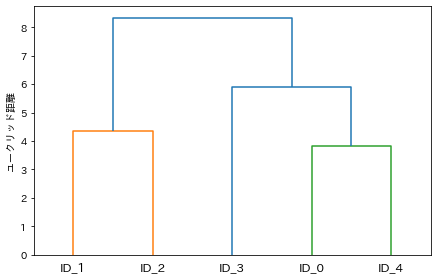

In [36]:
from scipy.cluster.hierarchy import dendrogram

#デンドログラムの表示
row_dendr = dendrogram(row_clusters,  
                       labels=labels,
                       )
plt.tight_layout()
plt.ylabel('ユークリッド距離')
plt.show()

<br>

## 樹形図をヒートマップと組み合わせる

<ipython-input-37-3a208a008f5f>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axm.set_xticklabels([''] + list(df_rowclust.columns))
<ipython-input-37-3a208a008f5f>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  axm.set_yticklabels([''] + list(df_rowclust.index))


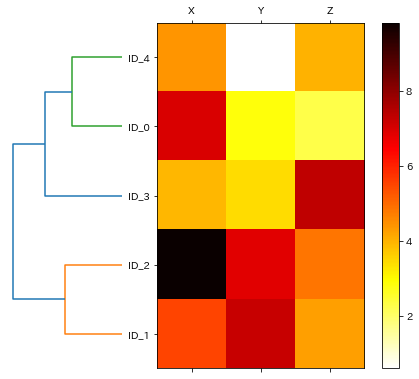

In [37]:
# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
    i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

#plt.savefig('images/11_12.png', dpi=300)
plt.show()

色より近いものが直感的にわかる。

<br>

## scikit-learnを使って凝集型階層的クラスタリングを適用する

In [9]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [1 2 0 0 2 2 1 1 1 1 0 1 2 1 0 1 0 1 0 0 2 1 0 1 0 1 2 2 1 0 1 0 1 0 0 2 1
 1 0 0 1 0 0 1 2 0 1 0 1 1 0 1 2 0 1 0 0 1 0 0 1 0 2 1 1 0 0 2 0 0 1 0 1 0
 1 0 0 1 0 1 2 0 1 2 0 0 1 0 1 2 0 1 2 0 2 2 2 1 0 1 1 2 0 1 0 0 0 0 2 0 0
 0 0 0 1 1 0 2 1 1 1 0 0 0 0 0 1 1 1 2 1 0 0 1 1 2 1 0 2 1 1 0 0 0 0 1 1 1
 0 0 1 2 1 0 1 0 1 1 0 0 1 1 0 2 1 2 0 1 2 1 0 0 0 0 1 1 2 0 0 0 2 0 2 2 2
 0 0 1 0 0 0 0 1 1 0 0 2 1 0 2]


In [10]:
#クラスターの数が2の場合
ac = AgglomerativeClustering(n_clusters=2, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 0
 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 1
 0 1 1 0 1 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1
 1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0
 1 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0 0 0
 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0]


ID_3はID_1とID_2より、ID_0とID_4の方が近いため、クラスター数が2つの場合は次に近いID_0とID_4に属される

<br>
<br>

# DBSCANを使って高密度の領域を特定する

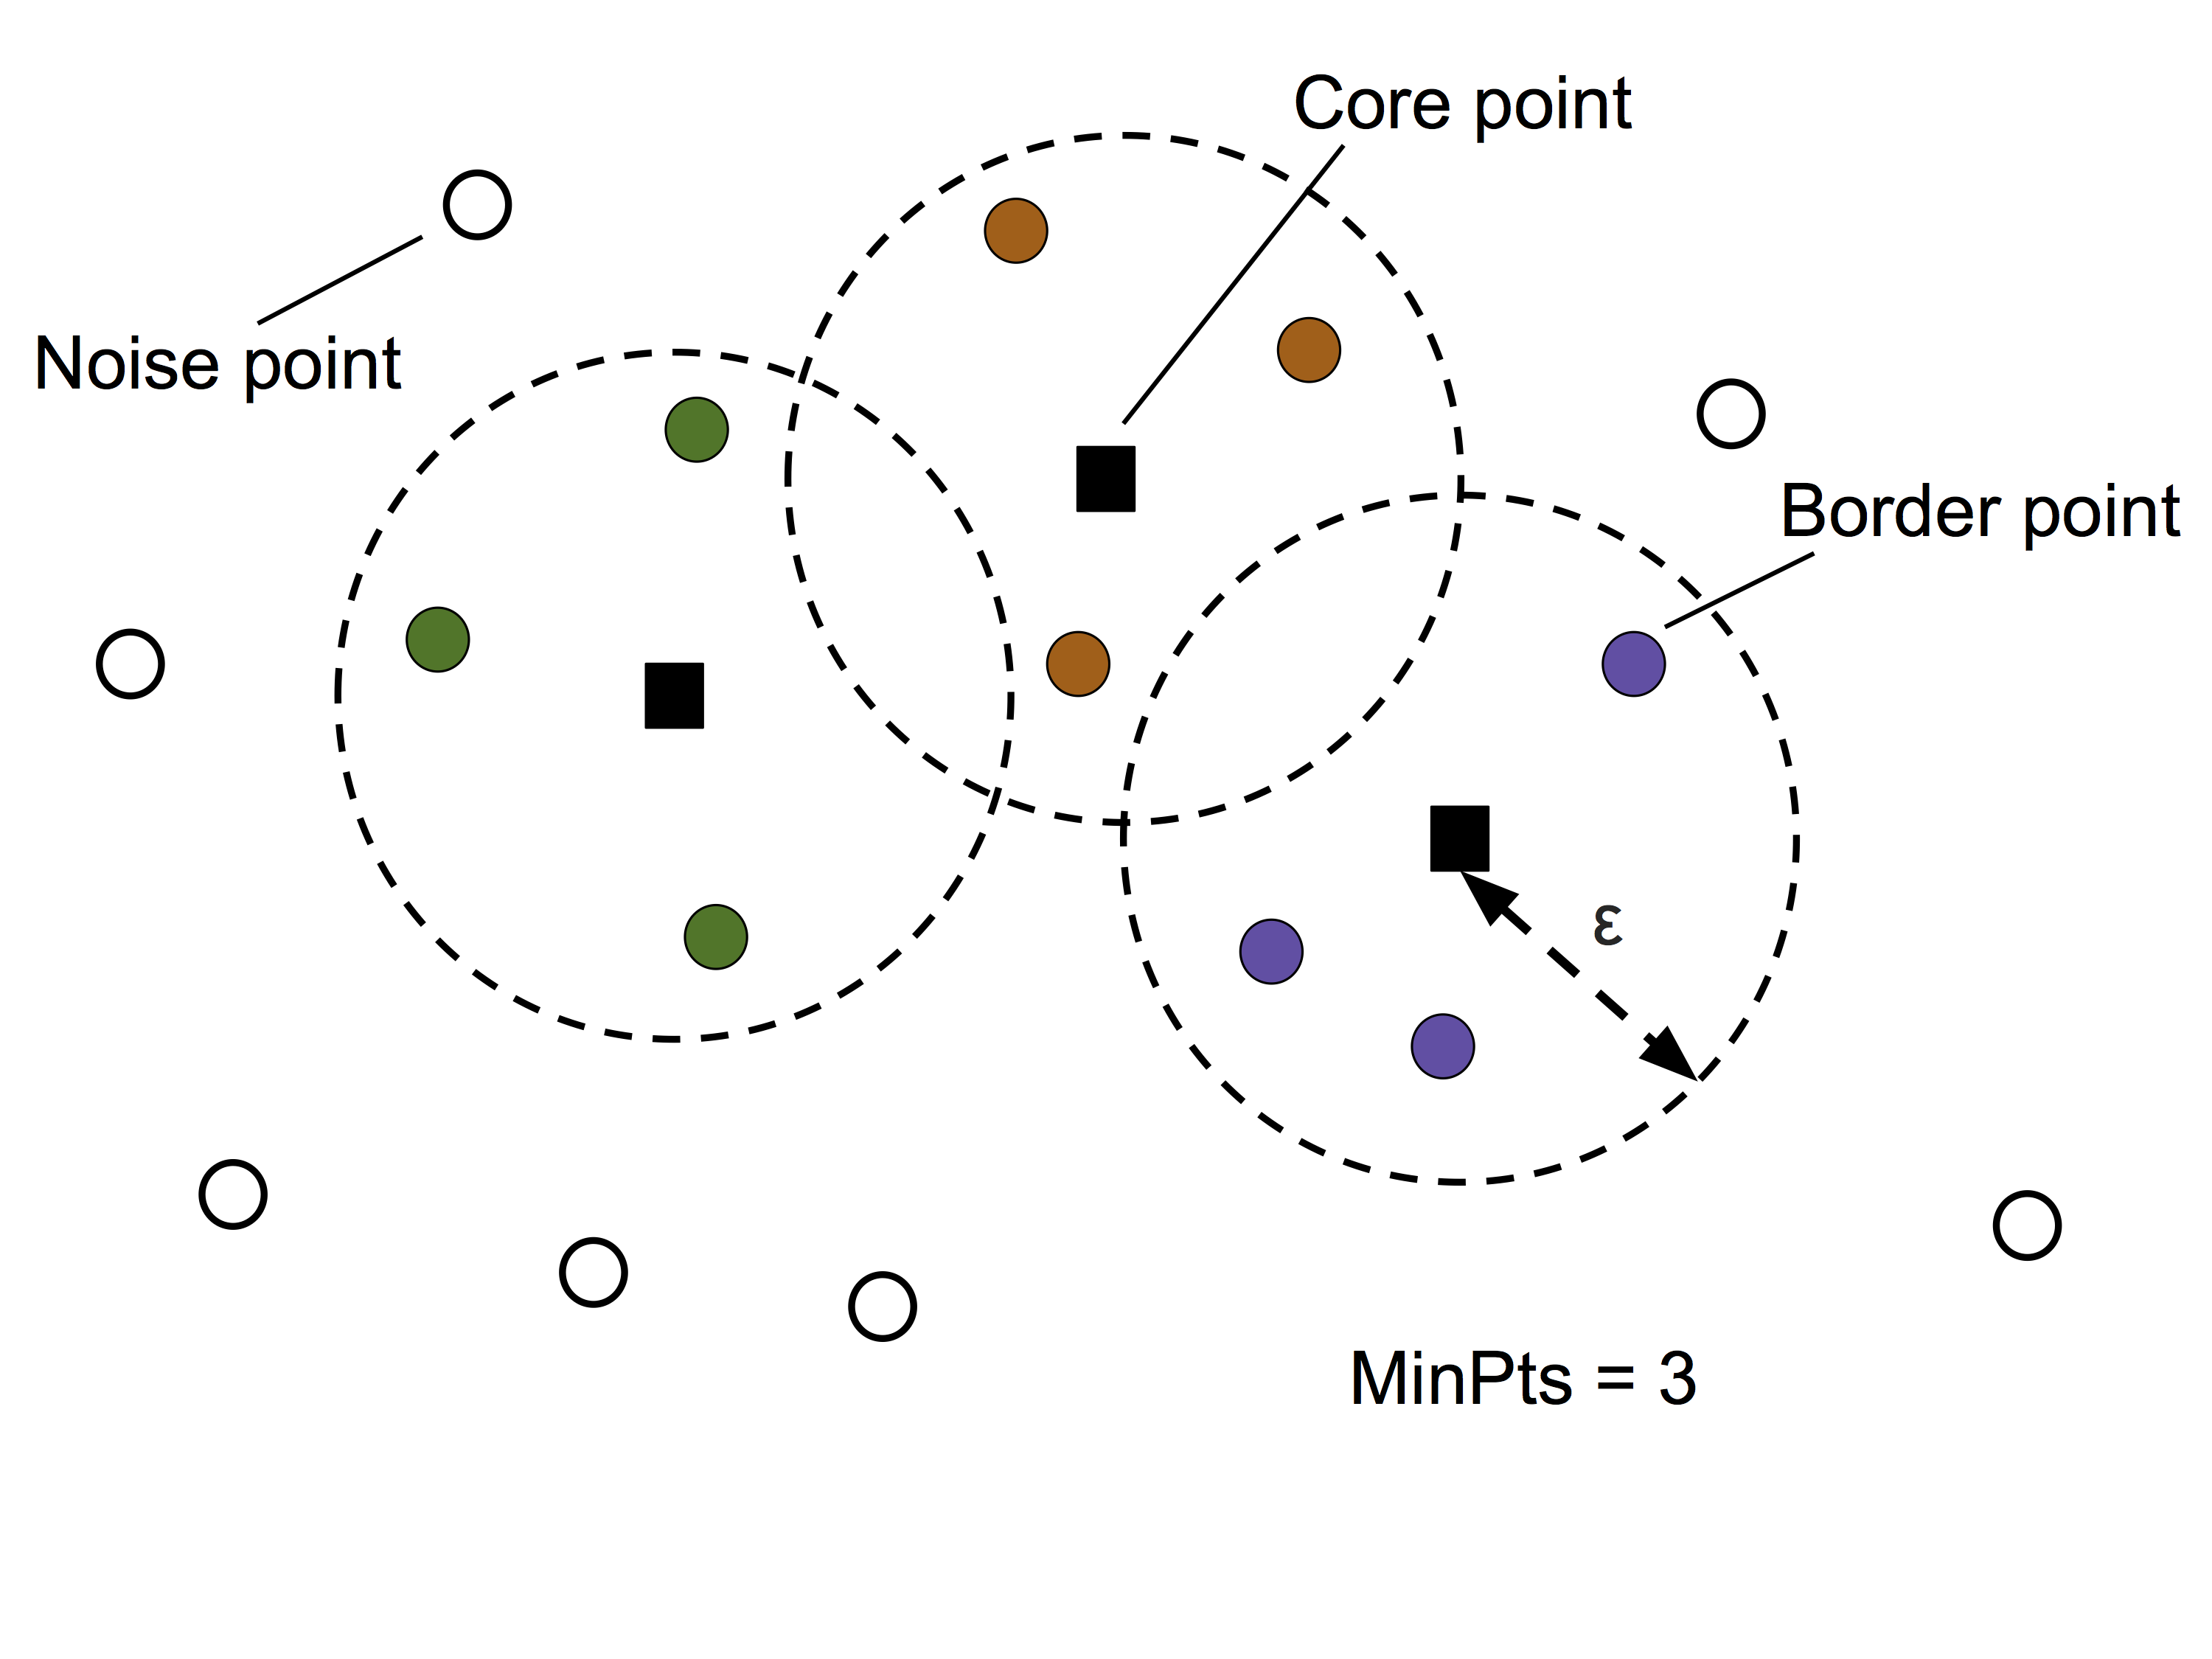

In [13]:
Image(filename='images/11_13.png', width=500) 

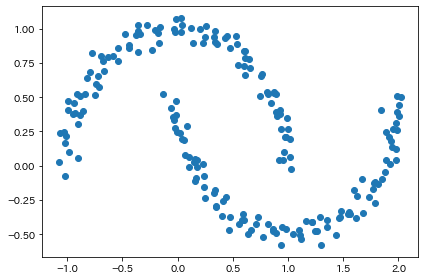

In [62]:
from sklearn.datasets import make_moons

#moonデータの生成
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
plt.show()

### K-means と 階層的クラスタリング:

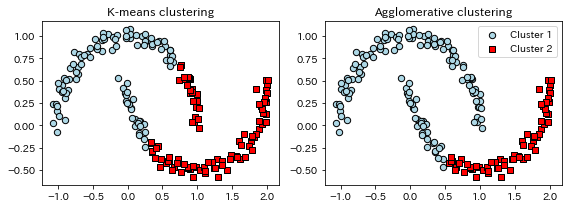

In [14]:
from sklearn.cluster import KMeans

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

#k-meansによるクラスタリングのプロット
km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')


ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='ward')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='Cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='Cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
plt.show()

### DBSCAN:

/var/folders/yw/rhny6n8d2252w05hgg3j0rcw0000gn/T/ipykernel_8708/2514520432.py:14: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[y_db == -1, 0], X[y_db == -1, 1],


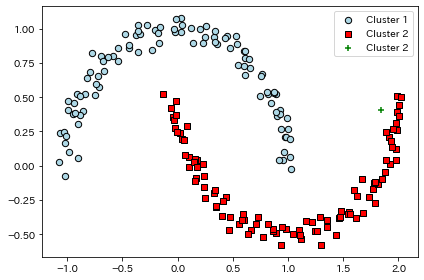

In [24]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.14, min_samples=3, metric='euclidean')
y_db = db.fit_predict(X)
# print(y_db)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='Cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='Cluster 2')
plt.scatter(X[y_db == -1, 0], X[y_db == -1, 1],
            c='green', marker='+', s=40,
            edgecolor='black', 
            label='Cluster 2')
plt.legend()
plt.tight_layout()
#plt.savefig('images/11_16.png', dpi=300)
plt.show()

ただし、$\varepsilon$(半径)と**最小データ数**はハイパーパラメータである。

#授業でやったeｐｓの目安。
https://ichi.pro/haipa-parame-ta-saitekika-o-shiyoshita-de-tasetto-de-no-k-means-kaisoteki-oyobi-dbscan-kurasutaringu-no-jitsuyoteki--208354183212927

### $\varepsilon$の目安の求め方

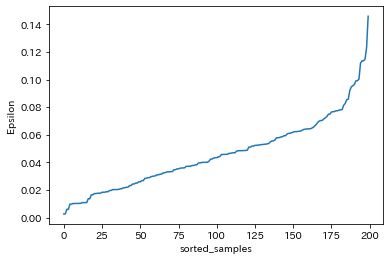

In [76]:
# we use nearestneighbors for calculating distance between points
from sklearn.neighbors import NearestNeighbors

# calculating distances
NN = NearestNeighbors(n_neighbors=2).fit(X)

# indices and distance values
distances,indices = NN.kneighbors(X)

# Now sorting the distance increasing order
sorting_distances=np.sort(distances,axis=0)

# sorted distances
sorted_distances=sorting_distances[:,1]
# print(sorted_distances)

# plot between distance vs epsilon
plt.plot(sorted_distances)
plt.xlabel('sorted_samples')
plt.ylabel('Epsilon')
plt.show()

indices 
 [[0 1 2 3]
 [1 0 2 3]
 [2 1 0 3]
 [3 4 5 0]
 [4 3 5 0]
 [5 4 3 0]]
distances 
 [[0.         1.         2.23606798 2.82842712]
 [0.         1.         1.41421356 3.60555128]
 [0.         1.41421356 2.23606798 5.        ]
 [0.         1.         2.23606798 2.82842712]
 [0.         1.         1.41421356 3.60555128]
 [0.         1.41421356 2.23606798 5.        ]]
[1.         1.         1.         1.         1.41421356 1.41421356]


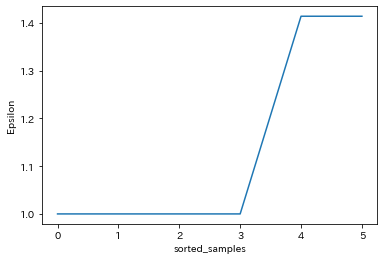

In [77]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
X1 = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
nbrs = NearestNeighbors(n_neighbors=4 ,  algorithm='ball_tree').fit(X1)
distances, indices = nbrs.kneighbors(X1)
print("indices \n", indices)
print("distances \n", distances)

# Now sorting the distance increasing order
sorting_distances=np.sort(distances,axis=0)

# sorted distances
sorted_distances=sorting_distances[:,1]
print(sorted_distances)

# plot between distance vs epsilon
plt.plot(sorted_distances)
plt.xlabel('sorted_samples')
plt.ylabel('Epsilon')
plt.show()

<br>
<br>

# まとめ

### 階層的と非階層的のメリットデメリット
- 階層メリット:　指定した距離指標から自分で適切な距離を選び、視覚的にクラスタリングがしやすい　説明性◯
- 非階層メリット:　ヒューリスティックな方法で計算コストが小さい→ビッグデータに対応　方法が理解しやすい

### k-meansとk-means++
基本++defaultもそう。
k-meansのデメリットとしては初期値によってクラスタリングの結果が変わることもあるため、
++で初期値を一定にする

### Fuzzy meansの活用
これはデータのクラスタへの所属を数値でみたいときに使う。出力が違う。
曖昧なデータを有る方法で分類したときに、これはこのクラスタですという出力よりも
このクラスタである確率が○○%といった方が都合が良い場合も有るだろう。(販促メールの例とか)

おまけ (最短距離法が使える例)　非線形可能 Ward法はG分布の等方分散性を持つクラスタリングになる。(球状)

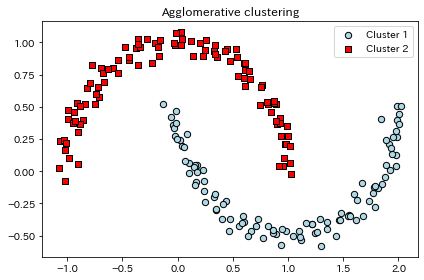

In [46]:
import seaborn as sns
from sklearn.cluster import KMeans

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='single')
y_ac = ac.fit_predict(X)
plt.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='Cluster 1')
plt.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='Cluster 2')
plt.title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
plt.show()

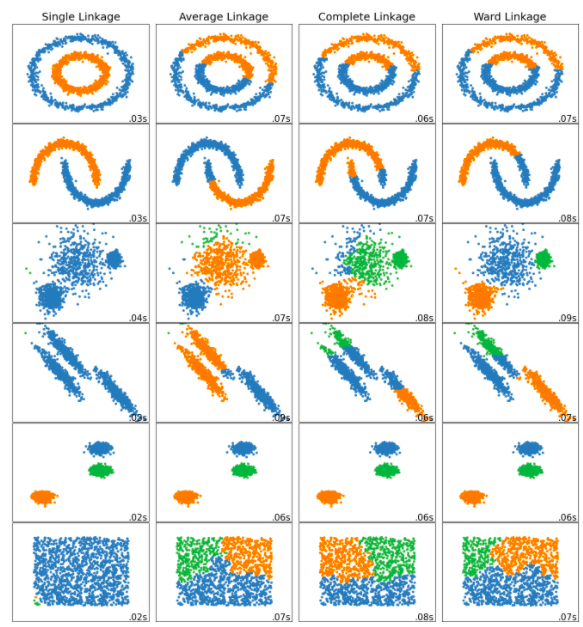

In [39]:
Image(filename='./images/11_2.png', width=600)

[階層的クラスタリングの連結法の違いによるクラスタリングの例(公式)](https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py)

おまけ DBSCAN

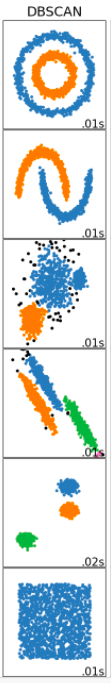

In [42]:
Image(filename='./images/11_3.png', width=100)

### 最後に、、

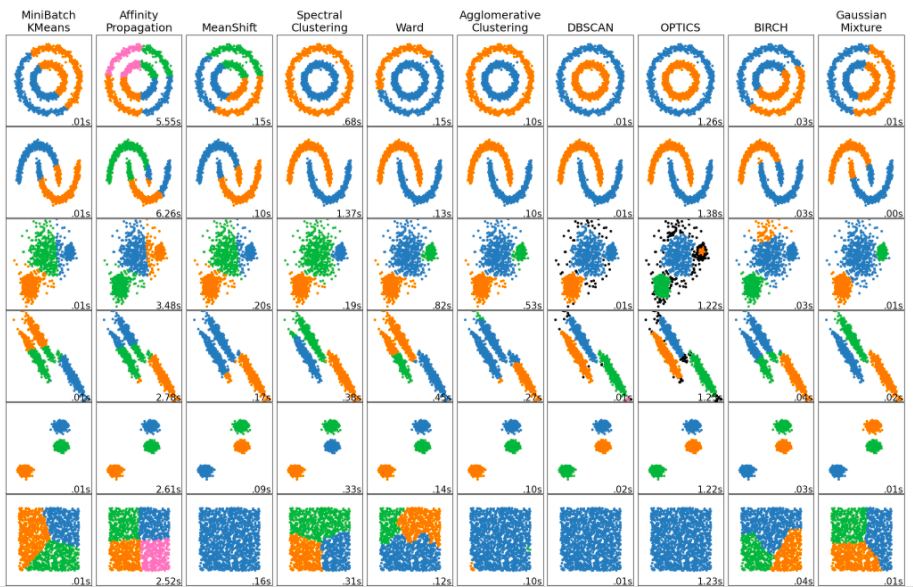

In [45]:
Image(filename='./images/11_4.png', width=900)

[クラスタリング手法まとめ(公式)](https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering)